In odrer to compare structured dropout and iid dropout in a linear model regime, we use the simulations embedded in sklearn (which make use of the Madelon synthetic dataset, see references in http://archive.ics.uci.edu/ml/datasets/madelon )
we vary: 
- the number of variables of redundant variables
- the number of overall variables 

we assess classification accuracy on a test set drawn from the same simulation



In [1]:
import sklearn
from sklearn.datasets import make_classification


import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')


x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
x_train=x_all[range(100),]
y_train=y_all[range(100),]
x_test=x_all[101:,]
y_test=y_all[101:]


dim = 1000 
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, nb_classes)
#y_test = to_categorical(y_test, nb_classes)

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size = 32

/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x_train shape: (100, 1000)
100 train samples
10000 test samples


In [4]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc


def dropout_layer(x, mode, l, dim):

    if mode == 'struc':
        xm = tf.reduce_mean(x, 0)
        cov = tf.matmul(tf.transpose(x-xm), x-xm) / batch_size
        cov += 1e-2 * tf.eye(dim, dtype='float32')
       # dia=tf.sqrt(tf.diag(1/tf.diag_part(cov)))
       # corr= tf.matmul(tf.matmul(dia,cov),dia)
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'iid':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    else:  # no dropout
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        self.dl = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.matmul(self.dl, W) + b

        # Minimize error using cross entropy
        self.probs = tf.nn.sigmoid(x)
        log_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})

                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies

For the training of the linear model, we simulate on 10 runs a set of 100 points with parameters listed in the paper, the model is either regularised using iid Gaussian dropout, Structured dropout (ASNI), or without regularisation. We test the model on each run, and for all regularisation parameters on one test dataset with 10,000 points, then average the accuracy on the 10 runs (and compute the standard deviation).   

In [ ]:



max_iters = 2000 
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=100, n_informative=10, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 100
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

In [ ]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})

                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 200 
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=100, n_informative=10, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 100
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

In [6]:
np.mean(acc_linear), np.std(acc_linear)

(0.6655, 0.0235405182610749)

In [7]:
np.mean(acc_iid), np.std(acc_iid)

(0.6834800000000001, 0.02014580849705467)

In [8]:
np.mean(acc_struc), np.std(acc_struc)

(0.6803999999999999, 0.01981706335459418)

In [ ]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})

                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 2000
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 1000
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

In [10]:
np.mean(acc_linear), np.std(acc_linear)

(0.68056, 0.02296654958847756)

In [11]:
np.mean(acc_iid), np.std(acc_iid)

(0.6864600000000001, 0.020661229392269956)

In [12]:
np.mean(acc_struc), np.std(acc_struc)

(0.68758, 0.022539955634384)

In [ ]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})

                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    #print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 2000
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=10000, n_informative=1000, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 10000
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

In [ ]:
np.mean(acc_linear), np.std(acc_linear)

In [ ]:
np.mean(acc_iid), np.std(acc_iid)

In [ ]:
np.mean(acc_struc), np.std(acc_struc)

In [ ]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})

                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 2000
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=100, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 1000
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

In [11]:
np.mean(acc_linear), np.std(acc_linear)

(0.65832, 0.016279975429956867)

In [12]:
np.mean(acc_iid), np.std(acc_iid)

(0.67628, 0.013198393841676362)

In [13]:
np.mean(acc_struc), np.std(acc_struc)

(0.68212, 0.013086389876509098)

We also compare fast structured dropout with structured dropout version : 

In [8]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc


def dropout_layer(x, mode, l, dim):

    if mode == 'struc':
        xm = tf.reduce_mean(x, 0)
        cov = tf.matmul(tf.transpose(x-xm), x-xm) / batch_size
        cov += 1e-2 * tf.eye(dim, dtype='float32')
       # dia=tf.sqrt(tf.diag(1/tf.diag_part(cov)))
       # corr= tf.matmul(tf.matmul(dia,cov),dia)
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'struc_fast':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        xm = tf.reduce_mean(x, 0)
        sample = tf.distributions.Normal(loc=tf.zeros(shape=[dim]),scale= tf.ones(shape=[dim])).sample()
        a= tf.expand_dims(sample,1)
        sample =  tf.matmul((x-xm),a)/ np.sqrt(batch_size)
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'iid':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    else:  # no dropout
        return x

In [ ]:
from time import time
max_iters = 2000
lambdas = [1e-2]


acc_fstruc=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=100, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 1000
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32


    print('#### fast_struc  #### iteration ',i)
    t0 = time()
    acc_fstruc_i=training(lambdas, 'iid', max_iters)
    acc_fstruc.append([np.max([np.max(acc) for acc in acc_fstruc_i])])
    t1 = time()
    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    t2 = time()


In [6]:
np.mean(acc_struc), np.std(acc_struc)

(0.6711, 0.022516482851457947)

In [7]:
np.mean(acc_fstruc), np.std(acc_fstruc)

(0.6693399999999998, 0.02531233691305489)

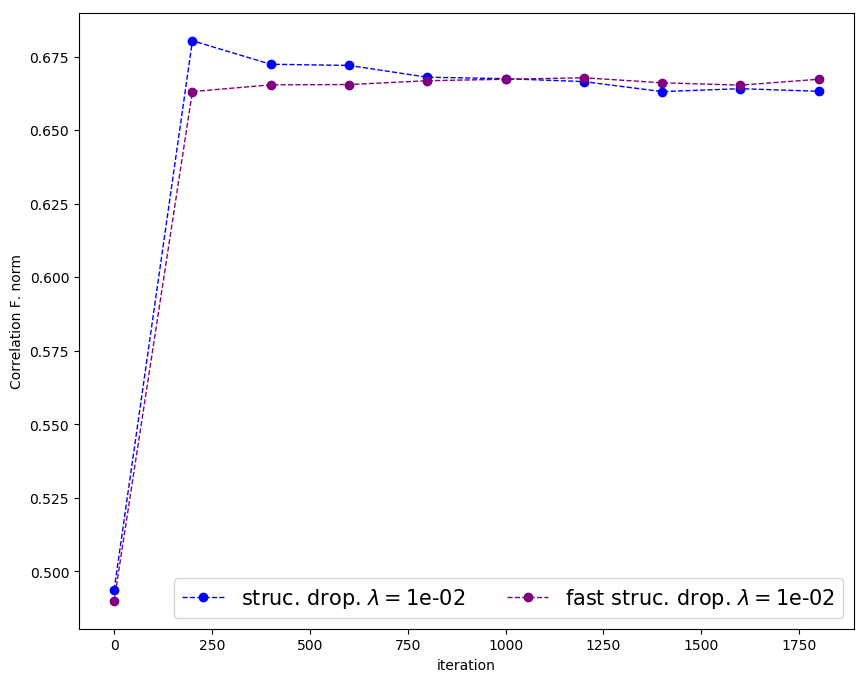

In [13]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

line_styles = ['--o', '--*', '--.','--+',':']

for i, series in enumerate(acc_struc_i):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'struc. drop. $\lambda=$%.0e' % lambdas[i])
    
for i, series in enumerate(acc_fstruc_i):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'fast struc. drop. $\lambda=$%.0e' % lambdas[i])


ax.set_xlabel('iteration')
ax.set_ylabel('Correlation F. norm')

# ax.set_ylim([0.8, 1.0])

plt.legend(ncol=2,prop={'size': 15})
plt.show()

In [14]:
print('average time for Fast structured dropout: ',t1-t0)

average time for Fast structured dropout:  3.4186959266662598


In [15]:
print('average time for  structured dropout: ',t2-t1)

average time for  structured dropout:  7.841660737991333
